In [ ]:
# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0,3,6'

In [2]:
no_of_gpu = 3

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
tqdm_notebook().pandas()
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import cv2
from os import listdir
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_hub as hub  #pip install tensorflow_hub
import os
from tokenization import FullTokenizer
# from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
# from keras import backend as K
# Initialize session
# sess = tf.Session()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) #command to run codeon multiple gpu



# Params for bert model and tokenization
# bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

bert_path = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"
from keras_lr_finder import LRFinder
import talos as ta
from pprint import pprint
from talos import live
tf.logging.set_verbosity(tf.logging.ERROR)
from random import choice
import gc


Using TensorFlow backend.


In [5]:
from talos.model.normalizers import lr_normalizer

In [6]:
np.random.seed(42)
tf.set_random_seed(42)

# Read data

In [7]:
!ls WeiboRumorSet/tweets/

test_nonrumor.txt  test_rumor.txt  train_nonrumor.txt  train_rumor.txt


In [8]:
!ls WeiboRumorSet/

images	   nonrumor_images  rumor_images	tweets
names.txt  readme.txt	    social_feature.txt


In [9]:
def get_df(file):
    return pd.read_csv(file, sep='|',header = None)

In [10]:
train_df_fake = get_df('WeiboRumorSet/tweets/train_rumor.txt')
train_df_real = get_df('WeiboRumorSet/tweets/train_nonrumor.txt')
test_df_fake = get_df('WeiboRumorSet/tweets/test_rumor.txt')
test_df_real = get_df('WeiboRumorSet/tweets/test_nonrumor.txt')

In [11]:
train_fake = train_df_fake[0].tolist()
train_real = train_df_real[0].tolist()
test_fake = test_df_fake[0].tolist()
test_real = test_df_real[0].tolist()

In [12]:
def fix_offset(list_):
    fixed_flag = False

    while not fixed_flag:
        exit_flag=False
        temp = copy.deepcopy(list_)
        for i,v in enumerate(temp):
            if v!=None:
                if 'sinaimg.cn' in v:
                    if list_[i+1] !=None:
                        if list_[i+1].isdigit():
                            list_.insert(i+1,None)
                            exit_flag=True
                            break
        if not exit_flag:
            fixed_flag=True
            
    return list_
    

In [13]:
train_fake = fix_offset(train_fake) 
train_real = fix_offset(train_real)
test_fake = fix_offset(test_fake)
test_real = fix_offset(test_real)

In [14]:
def break_in_block(list_):
    temp = []
    for i in range(0,len(list_),3):
        temp.append(list_[i:i+3])
    return temp

In [15]:
train_fake = break_in_block(train_fake)
train_real = break_in_block(train_real)
test_fake = break_in_block(test_fake)
test_real = break_in_block(test_real)

In [16]:
len(train_fake),len(train_real),len(test_fake),len(test_real)

(3748, 3783, 1000, 996)

In [17]:
def get_image_and_text_list(blocks_list):
    image_list = []
    text_list = []
    for i in blocks_list:
        if i[-1] !=None:
            image_list.append(i[1])
            text_list.append(i[-1])
    image_list = [i.split('/')[-1] for i in image_list]
    return image_list, text_list

In [18]:
train_fake_image,train_fake_text = get_image_and_text_list(train_fake)
train_real_image,train_real_text = get_image_and_text_list(train_real)
test_fake_image,test_fake_text = get_image_and_text_list(test_fake)
test_real_image,test_real_text = get_image_and_text_list(test_real)

In [19]:
train_fake_Y = [0]*len(train_fake_image)
train_real_Y = [1]*len(train_real_image)
test_fake_Y = [0]*len(test_fake_image)
test_real_Y = [1]*len(test_real_image)

In [20]:
train_images = train_fake_image+train_real_image
train_text = train_fake_text + train_real_text
trainY = train_fake_Y+train_real_Y

test_images = test_fake_image+test_real_image
test_text = test_fake_text+test_real_text
testY = test_fake_Y+test_real_Y

In [21]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(7481, 7481, 7481, 1930, 1930, 1930)

In [22]:
train_images = np.array(train_images)
train_text = np.array(train_text)
trainY = np.array(trainY)
test_images = np.array(test_images)
test_text = np.array(test_text)
testY = np.array(testY)

In [23]:
def index_to_delete(list_):
    list_images_dir = listdir('WeiboRumorSet/images/')
    gif_list = ['957e1cf2tw1e5foxts295g206o03p4qp.gif','a716fd45jw1ev0cgf8j46g209505zh4i.gif','005vnhZYgw1evupo8ttddg308w06o4qp.gif','7da75521gw1ele2jvi85rg2096056u0x.gif']
    index = []
    for i,v in enumerate(list_):
        if v not in list_images_dir:
            index.append(i)
        if v in gif_list:
            index.append(i)
    return index

In [24]:
train_delete_index =index_to_delete(train_images)
test_delete_index = index_to_delete(test_images)
len(train_delete_index)+len(test_delete_index)

4147

In [25]:
train_images = np.delete(train_images,train_delete_index)
train_text = np.delete(train_text,train_delete_index)
trainY = np.delete(trainY,train_delete_index)
test_images = np.delete(test_images,test_delete_index)
test_text = np.delete(test_text,test_delete_index)
testY = np.delete(testY,test_delete_index)

In [26]:
shuffle_index= np.arange(len(train_images))
np.random.shuffle(shuffle_index)
train_images = train_images[shuffle_index]
train_text = train_text[shuffle_index]
trainY = trainY[shuffle_index]

In [27]:
shuffle_index

array([3487, 1964, 1582, ..., 3092, 3772,  860])

In [28]:
len(train_images),len(train_text),len(trainY),len(test_images),len(test_text),len(testY)

(4140, 4140, 4140, 1124, 1124, 1124)

In [29]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s) for s in lines])

max len 498


(array([5.800e+02, 5.580e+02, 2.404e+03, 5.530e+02, 3.100e+01, 8.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 498]),
 <a list of 10 Patch objects>)

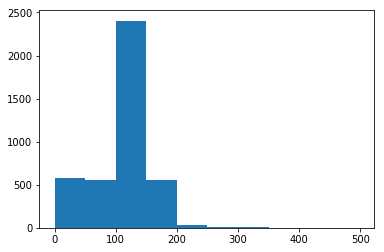

In [30]:
print(f'max len {max_length(train_text)}')
plt.hist([len(s) for s in train_text],bins=[0,50,100,150,200,250,300,350,400,450,498])

In [31]:
max_seq_length=200

# Text part

In [32]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, trainY 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, testY
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

# Image Part

In [33]:
length = 224
width = 224
channels = 3
+

In [34]:
error = []
def read_and_process_image(list_of_images):
    X = [] 
    for image in tqdm_notebook(list_of_images):
#         print(image)
        a = cv2.imread(image, cv2.IMREAD_COLOR)
        try:
            X.append(cv2.resize(a, (length,width), interpolation=cv2.INTER_CUBIC))  
        except:
            print(a)
            error.append(image)
    return X

In [35]:
train_images = ['WeiboRumorSet/images/'+i for i in train_images]
test_images = ['WeiboRumorSet/images/'+i for i in test_images]

In [36]:
train_imagesX = read_and_process_image(train_images)
test_imagesX = read_and_process_image(test_images)

In [37]:
error

[]

In [38]:
np.save('train_imagesX.npy', train_imagesX)
np.save('test_imagesX.npy', test_imagesX)

In [39]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [40]:
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX,3,1)

# The Model

In [41]:
class BertLayer(tf.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [42]:
def initialize_vars(sess):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) #command to run codeon multiple gpu
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [43]:
def news_model(x_train, y_train, x_val, y_val, params):
    
    try:
        del model
    except:
        pass
    K.clear_session()
    gc.collect()
    
    with tf.device('/cpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(3,224,224))
        conv_base.trainable=False
#         conv_base = base

        input_image = tf.keras.layers.Input(shape=(3,224,224))
        base_output = conv_base(input_image)
        flat = tf.keras.layers.Flatten()(base_output)

        if params['vis_no_hidden_layer']>0:
            for i in range(params['vis_no_hidden_layer']):
                flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
                flat = tf.keras.layers.Dropout(params['dropout'])(flat)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    model = tf.keras.utils.multi_gpu_model(model,gpus=no_of_gpu)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
#     model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])
    initialize_vars(sess)
    
    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    shuffle=True,
                    validation_data=[x_val, y_val],callbacks=[live()])
    
    return out, model



In [44]:

def get_news_model( params):
    
    K.clear_session()
    
    with tf.device('/cpu:0'):
        bert_base = BertLayer()
        bert_base.trainable= params['bert_trainable']

        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]
        bert_output = bert_base(bert_inputs)

        if params['text_no_hidden_layer']>0:
            for i in range(params['text_no_hidden_layer']):
                bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
                bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

        text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

        #image model
        conv_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(3,224,224))
        conv_base.trainable=False

        input_image = tf.keras.layers.Input(shape=(3,224,224))
        base_output = conv_base(input_image)
        flat = tf.keras.layers.Flatten()(base_output)

        if params['vis_no_hidden_layer']>0:
            for i in range(params['vis_no_hidden_layer']):
                flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
                flat = tf.keras.layers.Dropout(params['dropout'])(flat)

        visual_repr = tf.keras.layers.Dense(params['repr_size'],activation='relu')(flat)


        #classifier
        combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
        com_drop=tf.keras.layers.Dropout(params['dropout'])(combine_repr)

        if params['final_no_hidden_layer']>0:
            for i in range(params['final_no_hidden_layer']):
                com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
                com_drop=tf.keras.layers.Dropout(params['dropout'])(com_drop)

        prediction = tf.keras.layers.Dense(1,activation='sigmoid')(com_drop)

        model = tf.keras.models.Model(inputs=[in_id,in_mask,in_segment,input_image], outputs=prediction)

    model = tf.keras.utils.multi_gpu_model(model,gpus=no_of_gpu)
    
#     if params['optimizer'] == 'adam':
#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#     else:
#         opt = tf.keras.optimizers.RMSprop(lr=0.00005)
        
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    initialize_vars(sess)
    
    
    return model

# Learning rate finder on Twitter dataset best parameters

In [45]:
params_twitter_data = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':tf.keras.optimizers.Adam
}

In [46]:
model=get_news_model(params_twitter_data)

In [47]:
lr_finder = LRFinder(model)

In [48]:
lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.0001, 10, 256, 10)

Epoch 1/10
4140/4140 [==============================] - 43s 10ms/step - loss: 0.6253 - acc: 0.7077
Epoch 2/10
4140/4140 [==============================] - 26s 6ms/step - loss: 0.5148 - acc: 0.7717
Epoch 3/10
4140/4140 [==============================] - 26s 6ms/step - loss: 0.4349 - acc: 0.8121
Epoch 4/10
4140/4140 [==============================] - 26s 6ms/step - loss: 0.3715 - acc: 0.8386
Epoch 5/10
4140/4140 [==============================] - 26s 6ms/step - loss: 0.4358 - acc: 0.8314
Epoch 6/10
 512/4140 [==>...........................] - ETA: 22s - loss: 1.1632 - acc: 0.7949

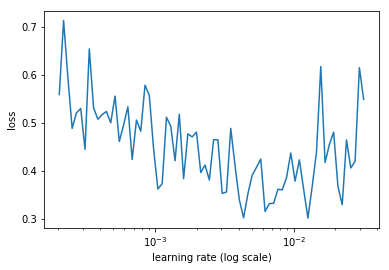

In [49]:
lr_finder.plot_loss()

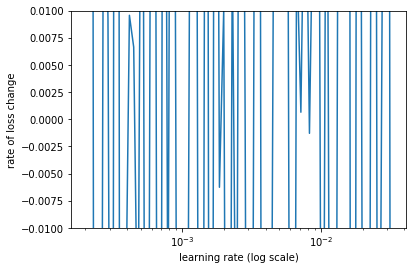

In [50]:
lr_finder.plot_loss_change()

In [51]:
K.set_value(model.optimizer.lr, 0.005)

In [52]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='max')  

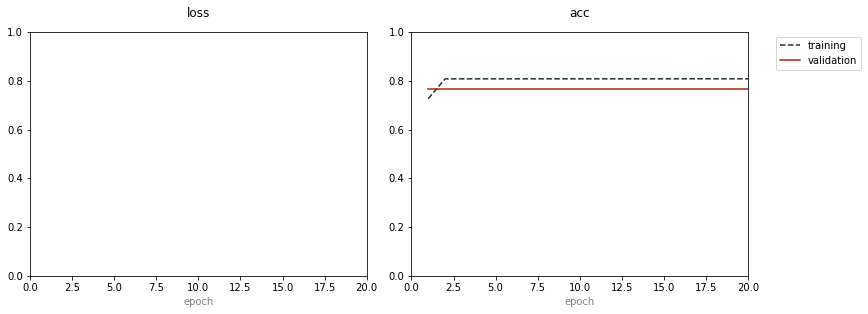


Epoch 00020: val_acc did not improve from 0.76690


In [53]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=256,
                    epochs=20,
                    verbose=0,
                    shuffle=True,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY),callbacks=[live(),checkpoint])

# Hyper patameter search 1

In [55]:
params = {
    'bert_trainable' :[False],
    'text_no_hidden_layer':(0,2,2),
    'text_hidden_neurons':[768,400],
    'dropout':(0.3,0.6,3),
    'repr_size':[32],
    'vis_no_hidden_layer':(0,2,2),
    'vis_hidden_neurons':[4096,2742],
    'final_no_hidden_layer':(0,2,2),
    'final_hidden_neurons':[64,35],
    'optimizer':['adam','rmsprop'],
    'batch_size':[256],
    'epochs':[3]
}

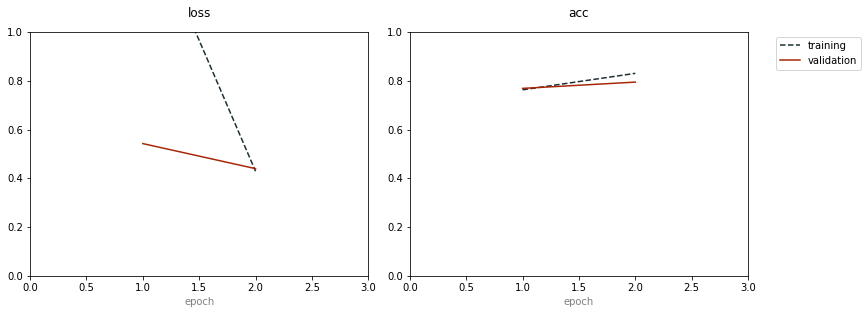

In [ ]:
h = ta.Scan([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, params=params,
            model=news_model,
            dataset_name='chiness_fake_news',
            experiment_no='1',
            x_val=[test_input_ids, test_input_masks, test_segment_ids,test_imagesX],
            y_val=testY,
            grid_downsample=.08)

## Lets look at Hyper parameter experiment 1 

In [59]:
r = ta.Reporting(h)
# r = ta.Reporting('chiness_fake_news_1.csv')

In [60]:
r.high('val_acc')

0.8309608540925267

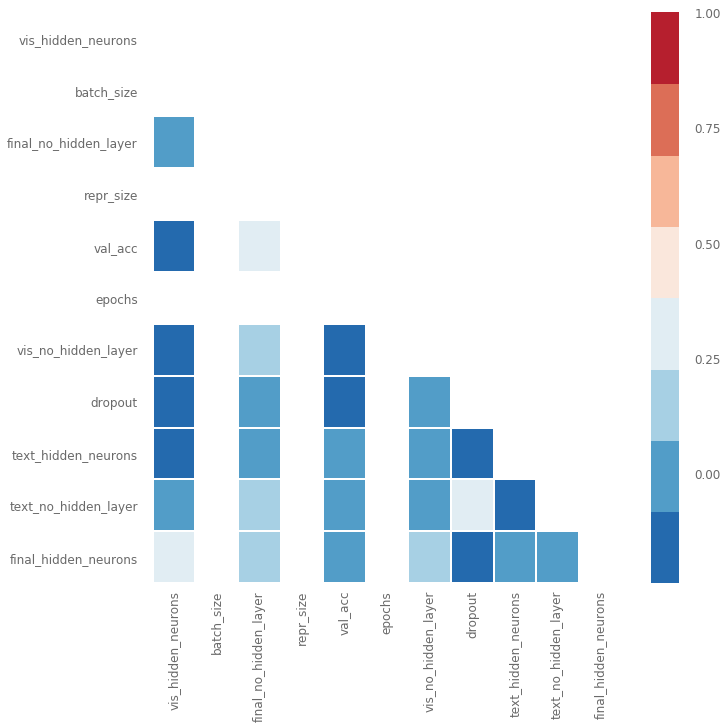

In [61]:
r.plot_corr()

bert_trainable
text_no_hidden_layer
text_hidden_neurons
dropout
repr_size
vis_no_hidden_layer
vis_hidden_neurons
final_no_hidden_layer
final_hidden_neurons
optimizer
batch_size
epochs


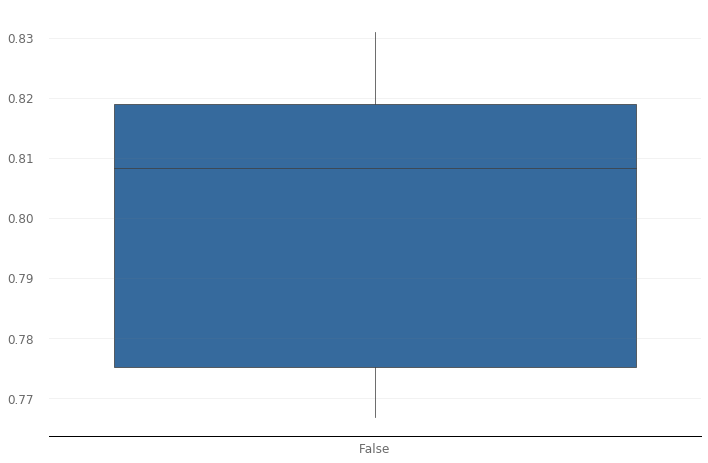

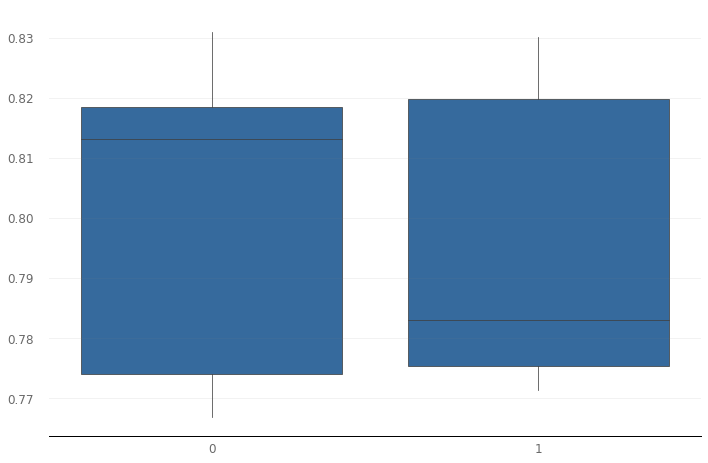

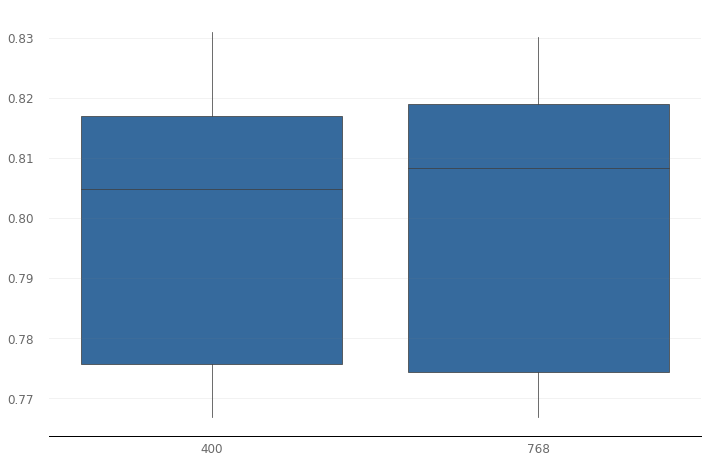

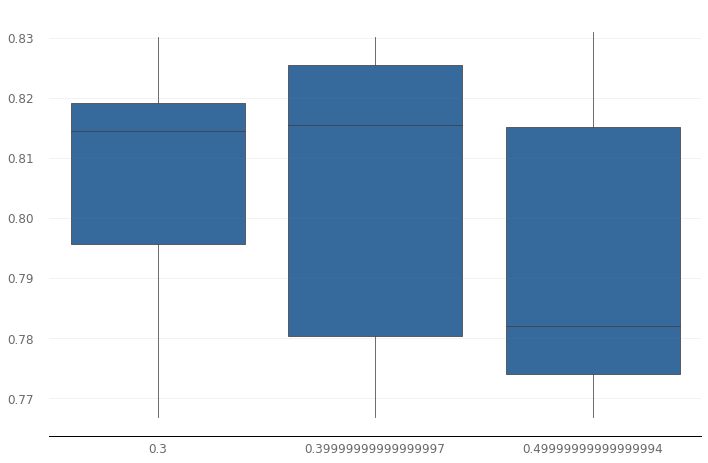

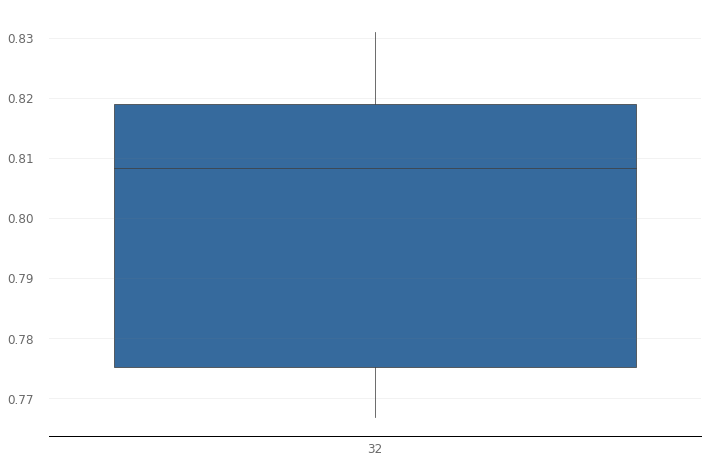

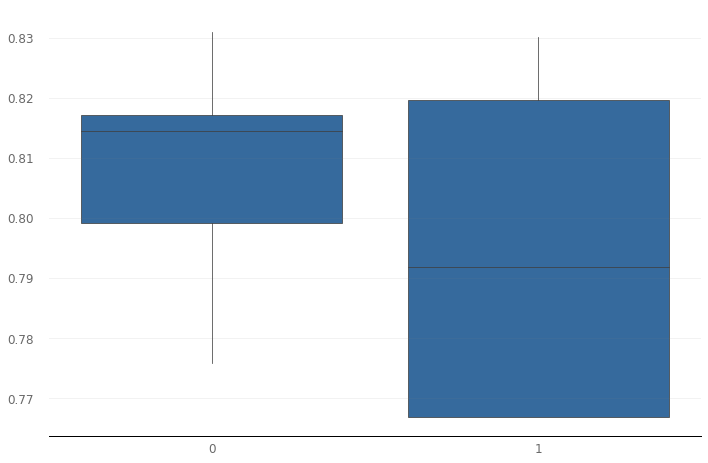

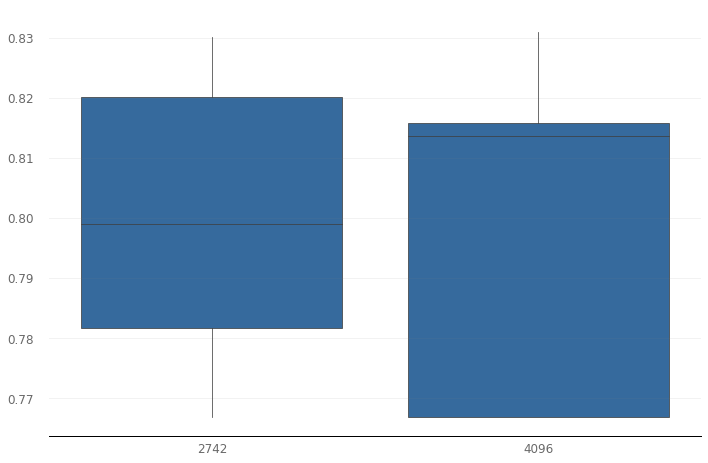

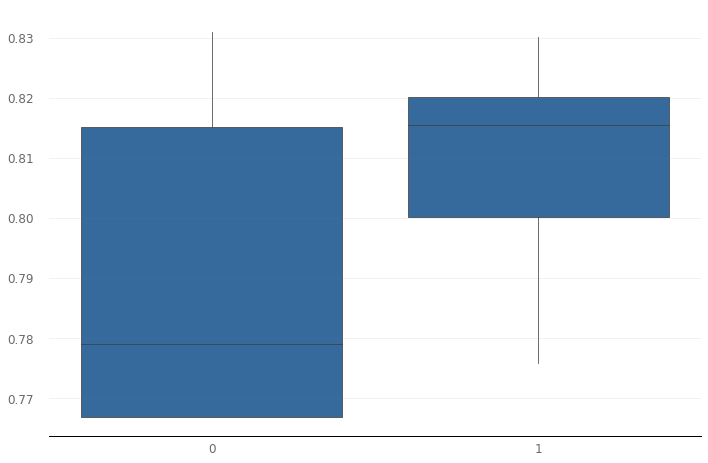

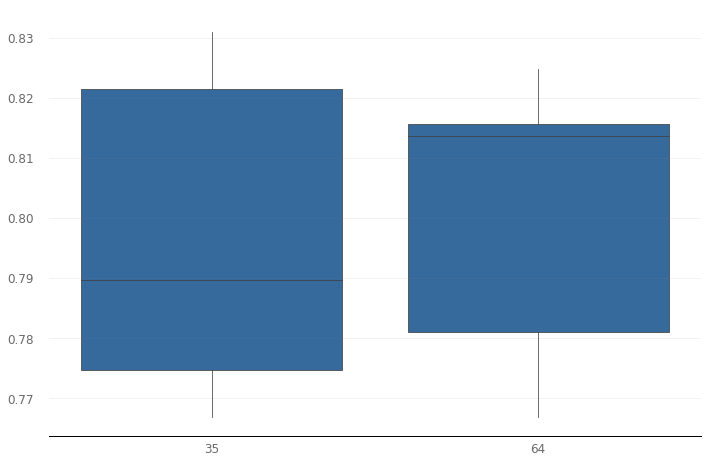

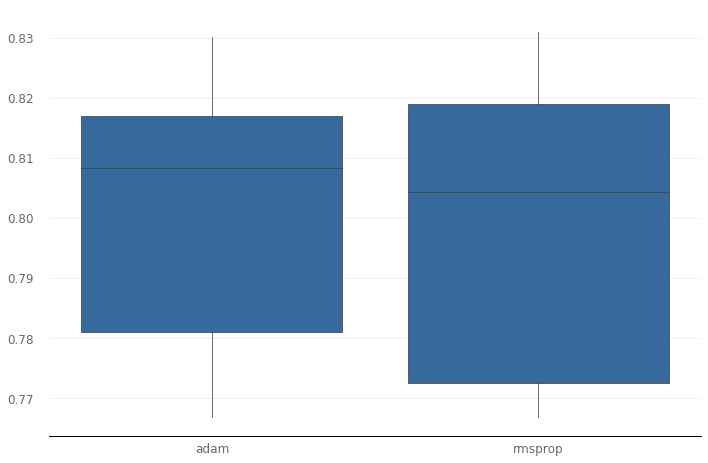

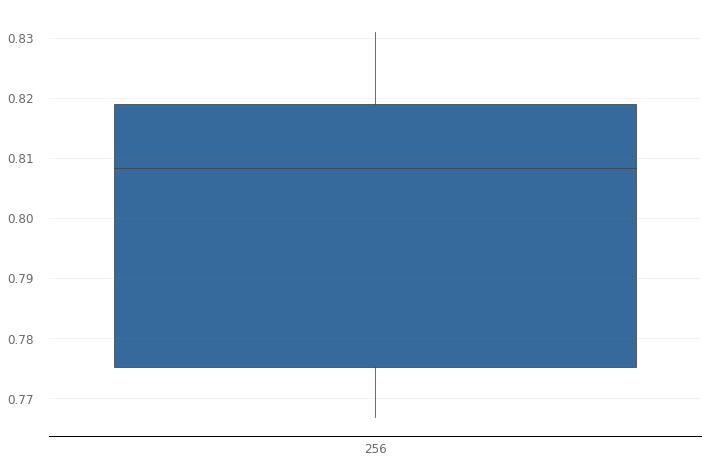

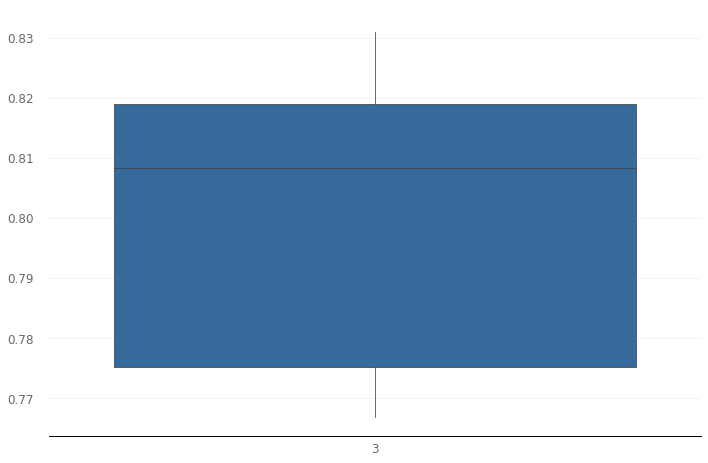

In [62]:
for k in params.keys():
    print(k)
    r.plot_box(y='val_acc',x=k)

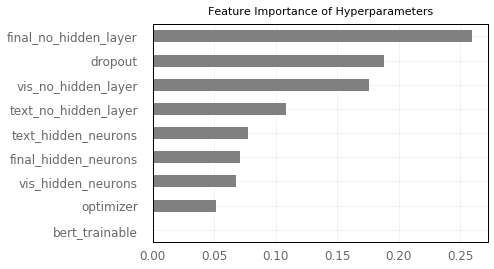

In [63]:
from sklearn.preprocessing import MinMaxScaler

X = r.data[['bert_trainable','text_no_hidden_layer','text_hidden_neurons','dropout','vis_no_hidden_layer','vis_hidden_neurons','final_no_hidden_layer','final_hidden_neurons','optimizer']]
scaler = MinMaxScaler()
y = scaler.fit_transform(r.data[['val_acc']])
X['bert_trainable'] = pd.factorize(X['bert_trainable'])[0]
X['optimizer'] = pd.factorize(X['optimizer'])[0]
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=3,n_estimators=100)
reg.fit(X,y)
pd.Series(reg.feature_importances_,index=X.columns).\
sort_values(ascending=True).plot.barh(color='grey',title='Feature Importance of Hyperparameters')

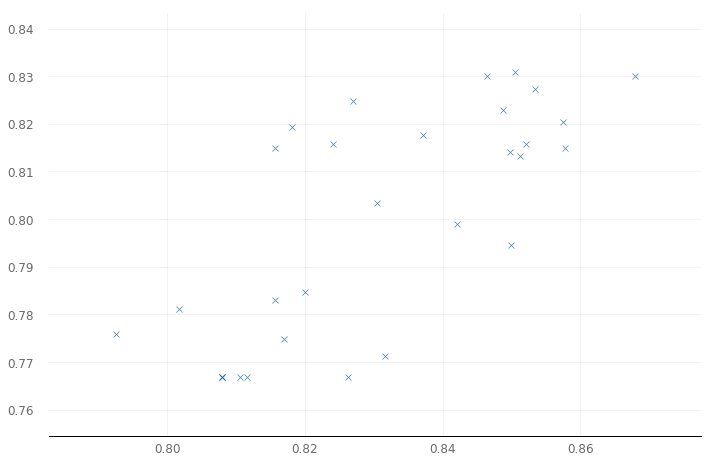

In [64]:
r.plot_regs(x='acc',y='val_acc')

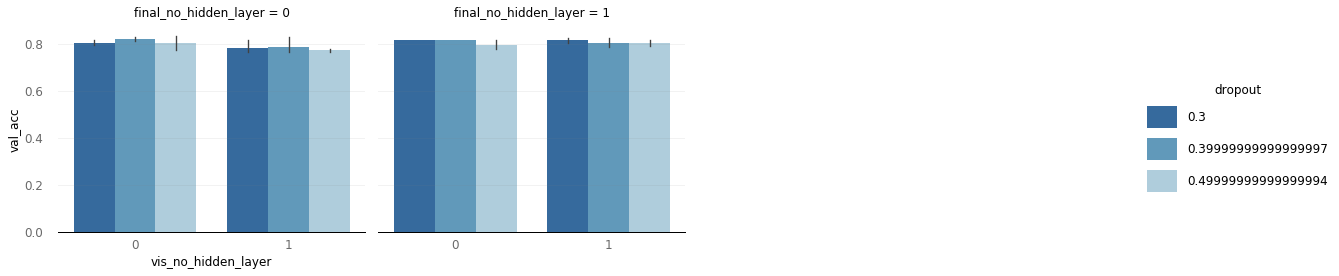

In [65]:
r.plot_bars(x='vis_no_hidden_layer',y='val_acc',hue='dropout',col='final_no_hidden_layer')

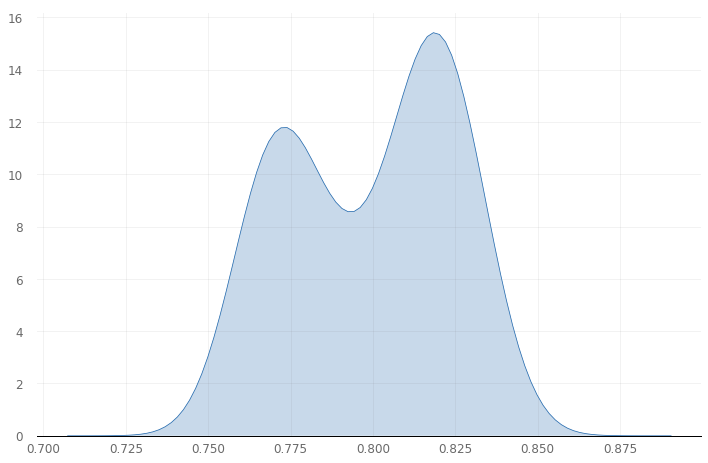

In [67]:
r.plot_kde()

In [68]:
r.data

,round_epochs,val_loss,val_acc,loss,acc,bert_trainable,text_no_hidden_layer,text_hidden_neurons,dropout,repr_size,vis_no_hidden_layer,vis_hidden_neurons,final_no_hidden_layer,final_hidden_neurons,optimizer,batch_size,epochs
0,3,0.412353,0.815836,0.366472,0.852174,False,0,400,0.3,32,1,4096,0,35,adam,256,3
1,3,0.457777,0.781139,0.449915,0.801691,False,0,400,0.5,32,1,2742,1,35,rmsprop,256,3
2,3,0.419918,0.784698,0.399365,0.820048,False,0,400,0.4,32,1,2742,1,35,adam,256,3
3,3,0.488341,0.775801,0.469698,0.792512,False,1,400,0.5,32,0,4096,1,35,rmsprop,256,3
4,3,0.457858,0.798932,0.383433,0.842029,False,0,768,0.3,32,1,4096,1,64,adam,256,3
5,3,0.415371,0.774911,0.412567,0.816908,False,1,400,0.5,32,1,2742,0,64,adam,256,3
6,3,0.408569,0.803381,0.395928,0.830435,False,0,768,0.5,32,1,2742,1,64,adam,256,3
7,3,0.428544,0.813167,0.375277,0.851208,False,0,768,0.4,32,0,4096,0,64,adam,256,3
8,3,0.419095,0.814057,0.373091,0.849758,False,0,768,0.3,32,0,4096,1,64,rmsprop,256,3
9,3,0.379411,0.827402,0.356345,0.853382,False,0,768,0.4,32,0,2742,0,35,rmsprop,256,3


# Hyperparameter experiment no 2

In [70]:
params = {
    'bert_trainable' :[False],
    'text_no_hidden_layer':(0,2,2),
    'text_hidden_neurons':[768,400],
    'dropout':(0.3,0.6,3),
    'repr_size':[32],
    'vis_no_hidden_layer':(0,2,2),
    'vis_hidden_neurons':[4096,2742],
    'final_no_hidden_layer':(0,2,2),
    'final_hidden_neurons':[64,35],
    'optimizer':['adam','rmsprop'],
    'batch_size':[256],
    'epochs':[10]
}

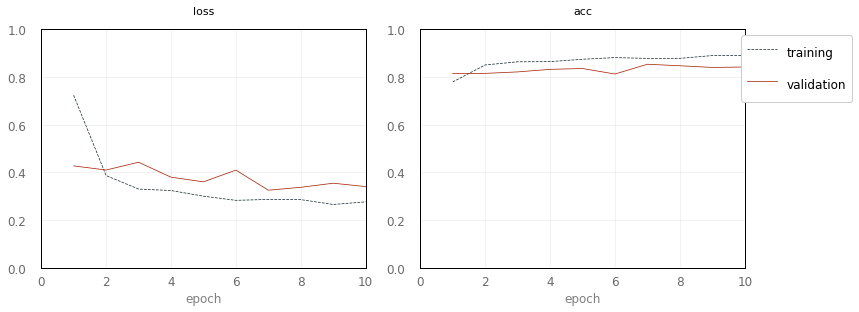

100%|██████████| 30/30 [2:50:04<00:00, 326.72s/it]


In [71]:
h = ta.Scan([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, params=params,
            model=news_model,
            dataset_name='chiness_fake_news',
            experiment_no='2',
            x_val=[test_input_ids, test_input_masks, test_segment_ids,test_imagesX],
            y_val=testY,
            grid_downsample=.08)

In [72]:
r = ta.Reporting(h)

In [73]:
r.high('val_acc')

0.8674377200866509

In [74]:
r.data.sort_values('val_acc').tail()

,round_epochs,val_loss,val_acc,loss,acc,bert_trainable,text_no_hidden_layer,text_hidden_neurons,dropout,repr_size,vis_no_hidden_layer,vis_hidden_neurons,final_no_hidden_layer,final_hidden_neurons,optimizer,batch_size,epochs
27,10,0.319719,0.859431,0.265550,0.890821,False,1,768,0.4,32,0,4096,0,64,adam,256,10
24,10,0.316719,0.859431,0.253544,0.892754,False,1,400,0.5,32,1,4096,0,35,adam,256,10
3,10,0.315661,0.862100,0.237169,0.904831,False,1,400,0.3,32,0,2742,0,35,adam,256,10
20,10,0.313762,0.862100,0.280370,0.880435,False,1,768,0.4,32,0,2742,1,35,adam,256,10
16,10,0.308678,0.867438,0.240164,0.900725,False,1,400,0.3,32,0,2742,1,64,adam,256,10


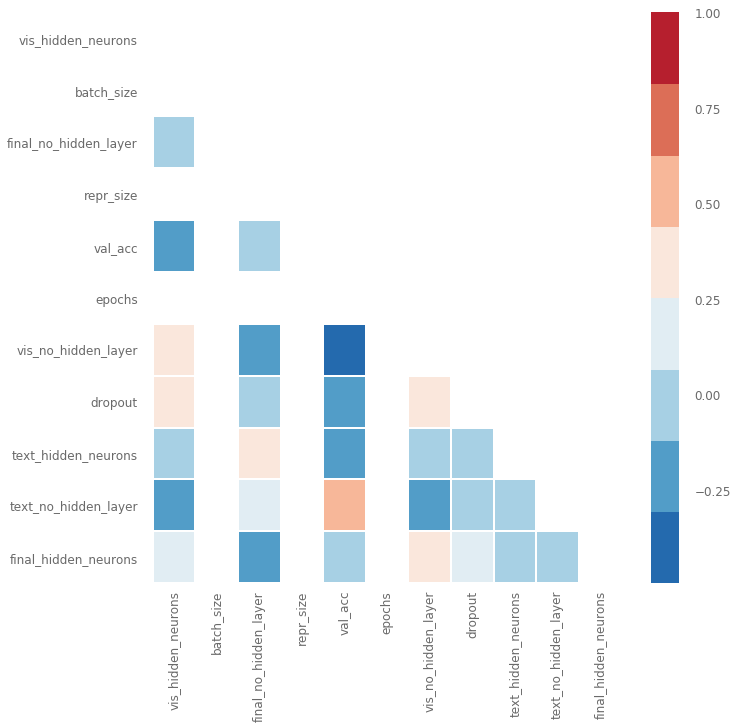

In [75]:
r.plot_corr()

bert_trainable
text_no_hidden_layer
text_hidden_neurons
dropout
repr_size
vis_no_hidden_layer
vis_hidden_neurons
final_no_hidden_layer
final_hidden_neurons
optimizer
batch_size
epochs


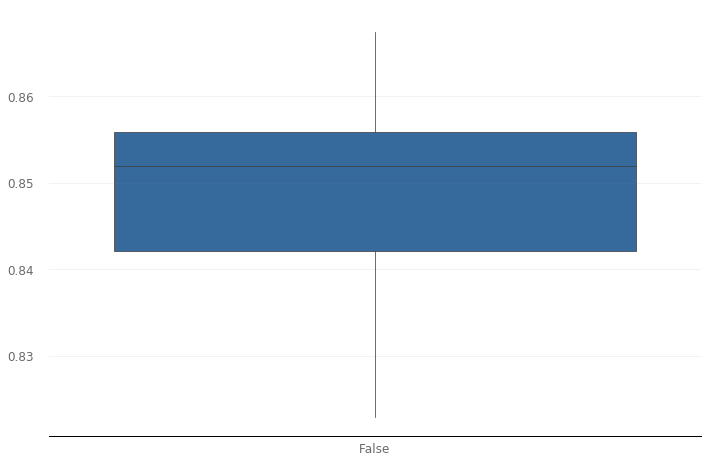

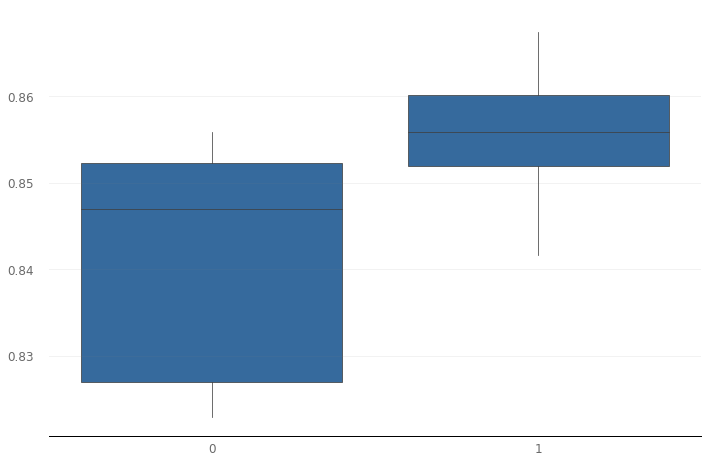

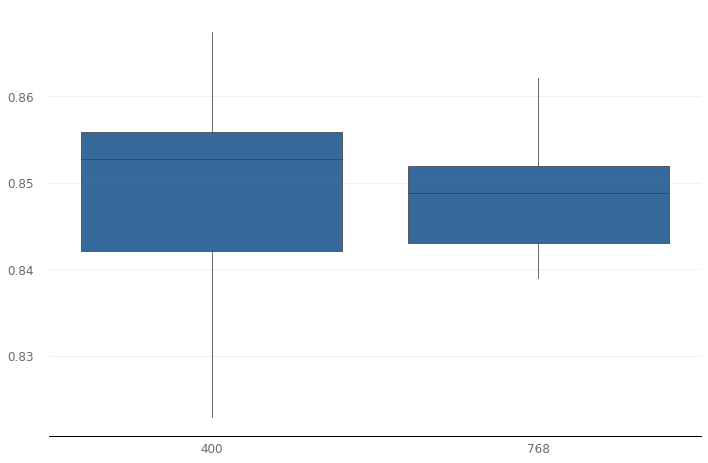

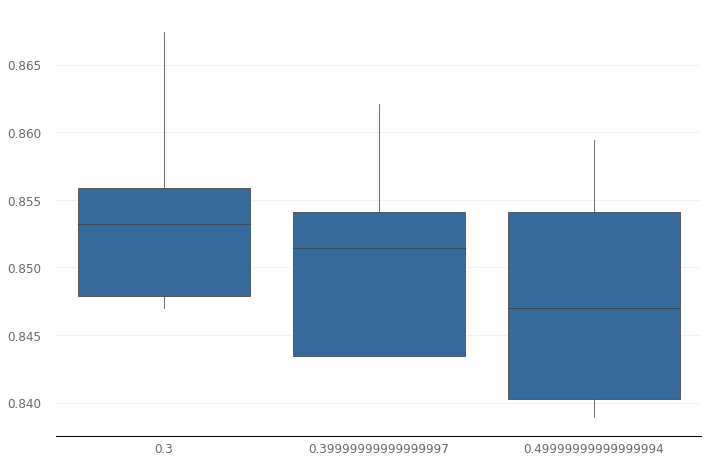

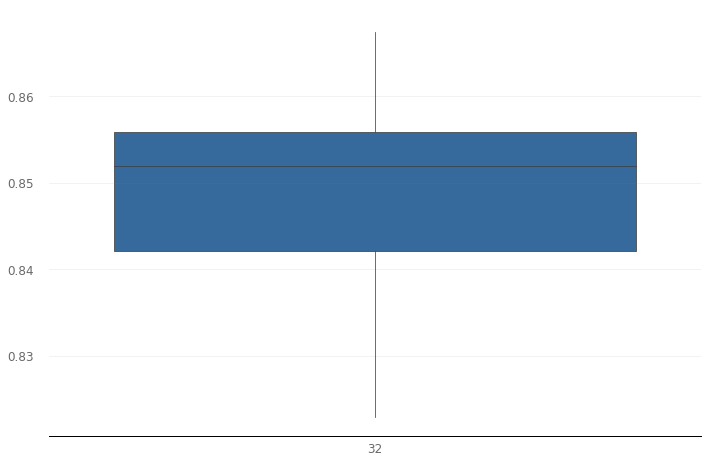

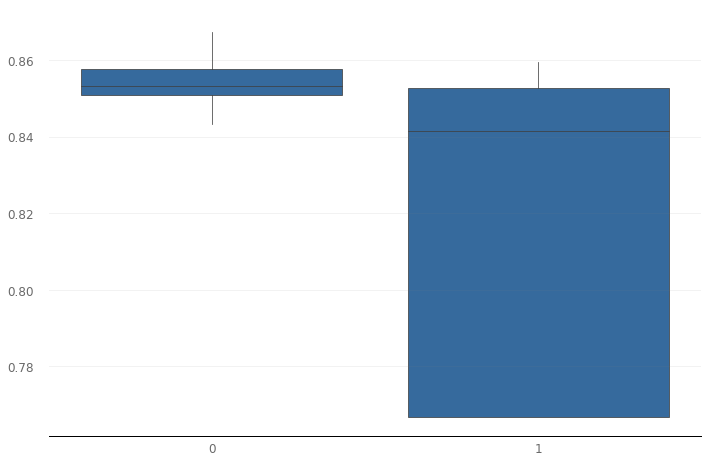

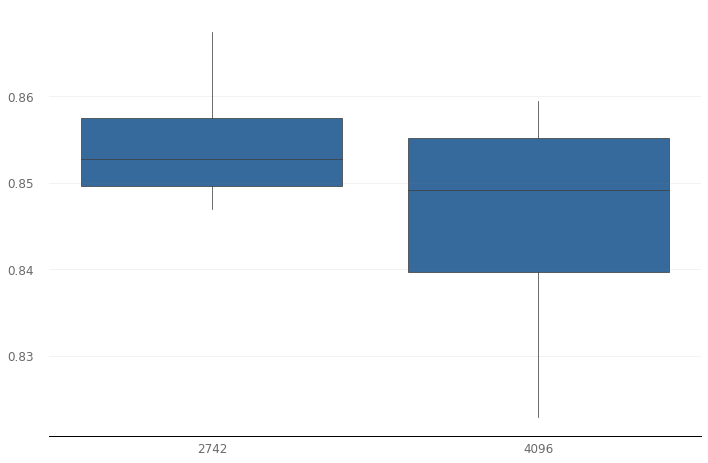

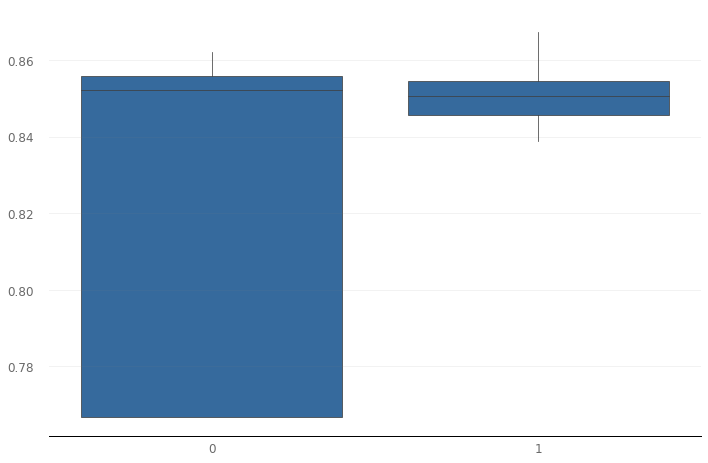

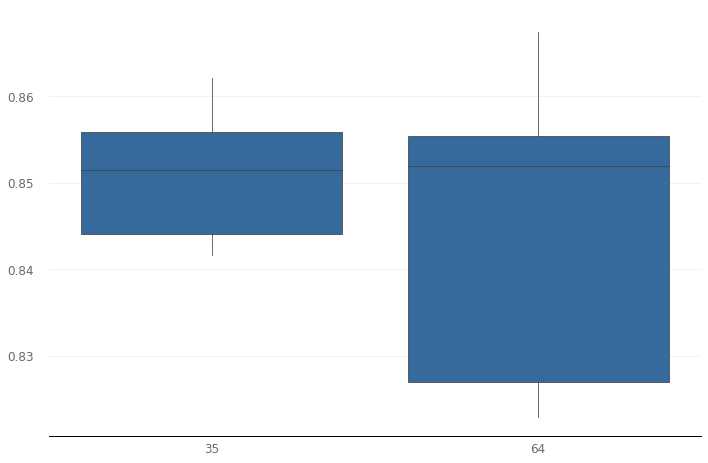

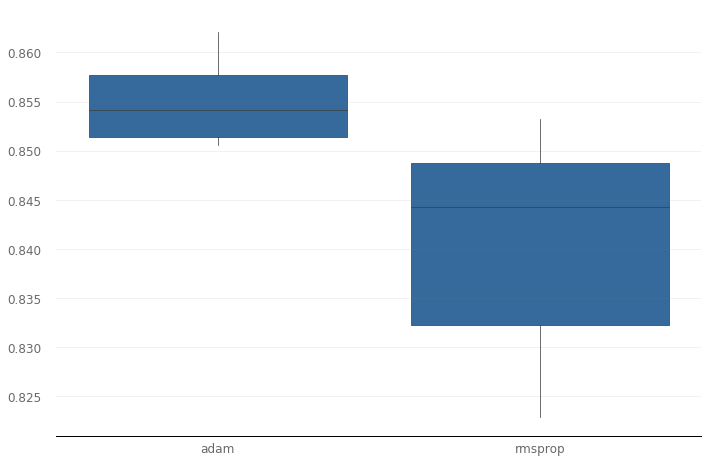

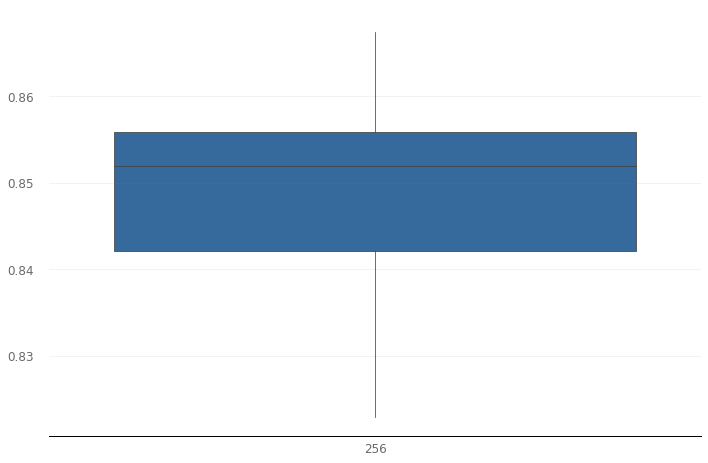

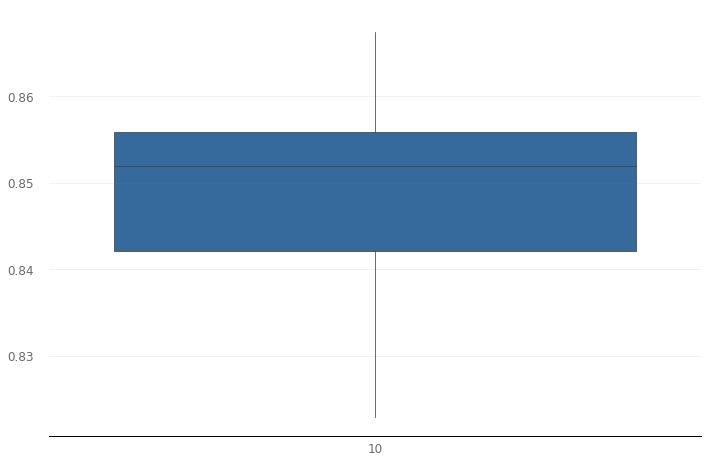

In [76]:
for k in params.keys():
    print(k)
    r.plot_box(y='val_acc',x=k)

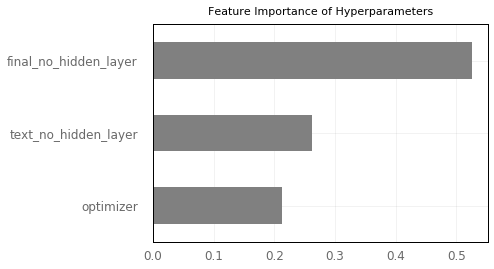

In [78]:
from sklearn.preprocessing import MinMaxScaler

X = r.data[['text_no_hidden_layer','final_no_hidden_layer','optimizer']]
scaler = MinMaxScaler()
y = scaler.fit_transform(r.data[['val_acc']])
X['optimizer'] = pd.factorize(X['optimizer'])[0]
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=3,n_estimators=100)
reg.fit(X,y)
pd.Series(reg.feature_importances_,index=X.columns).\
sort_values(ascending=True).plot.barh(color='grey',title='Feature Importance of Hyperparameters')

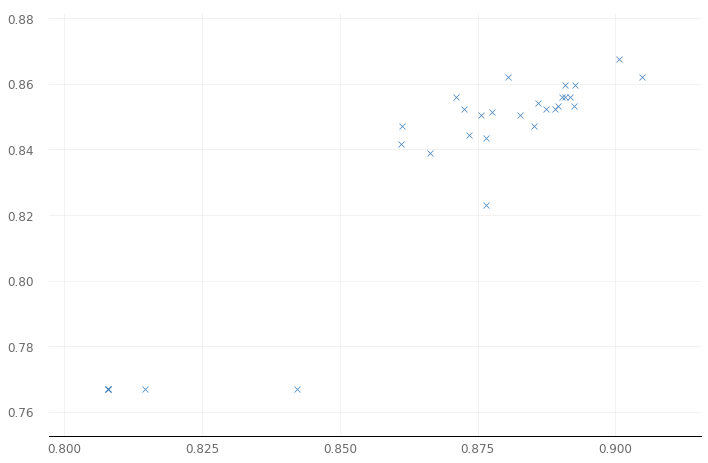

In [79]:
r.plot_regs(x='acc',y='val_acc')

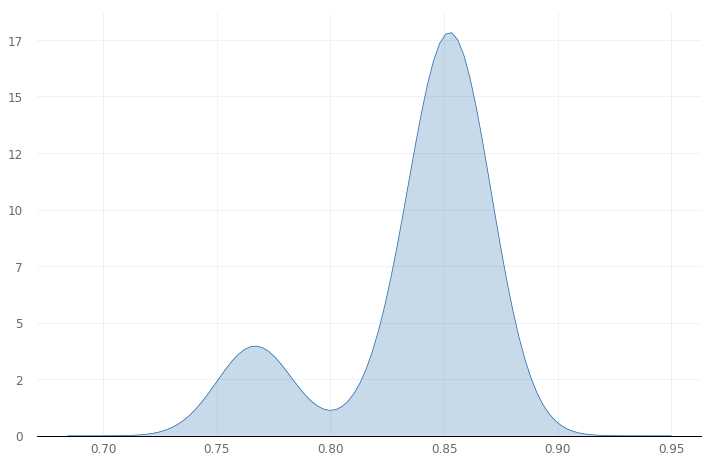

In [80]:
r.plot_kde()

Using LR finder to find best learning rate

In [83]:
r.data.sort_values('val_acc').tail()

,round_epochs,val_loss,val_acc,loss,acc,bert_trainable,text_no_hidden_layer,text_hidden_neurons,dropout,repr_size,vis_no_hidden_layer,vis_hidden_neurons,final_no_hidden_layer,final_hidden_neurons,optimizer,batch_size,epochs
27,10,0.319719,0.859431,0.265550,0.890821,False,1,768,0.4,32,0,4096,0,64,adam,256,10
24,10,0.316719,0.859431,0.253544,0.892754,False,1,400,0.5,32,1,4096,0,35,adam,256,10
3,10,0.315661,0.862100,0.237169,0.904831,False,1,400,0.3,32,0,2742,0,35,adam,256,10
20,10,0.313762,0.862100,0.280370,0.880435,False,1,768,0.4,32,0,2742,1,35,adam,256,10
16,10,0.308678,0.867438,0.240164,0.900725,False,1,400,0.3,32,0,2742,1,64,adam,256,10


In [85]:
params_final = {
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':400,
    'dropout':0.3,
    'repr_size':32,
    'vis_no_hidden_layer':0,
    'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':64,
    'optimizer':tf.keras.optimizers.Adam
}

In [86]:
model=get_news_model(params_final)

In [87]:
# K.set_value(model.optimizer.lr, 0.0005)

In [88]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='max')  

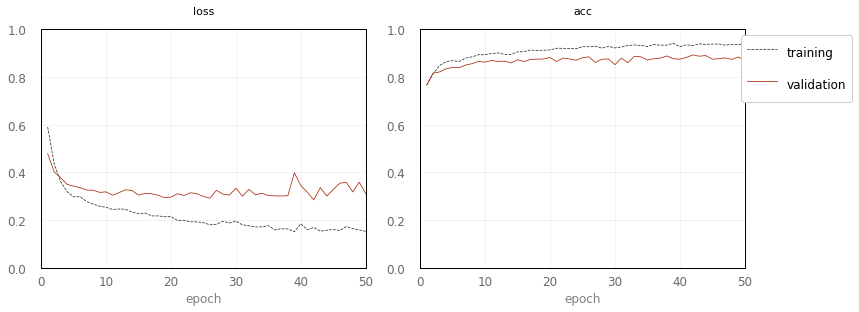


Epoch 00050: val_acc did not improve from 0.89235


In [89]:
out = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY,
                    batch_size=256,
                    epochs=50,
                    verbose=0,
                    shuffle=True,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY),callbacks=[live(),checkpoint])

In [90]:
model=get_news_model(params_final)

In [91]:
model.load_weights('model-042-0.892349.h5')

In [92]:
test_predict = model.predict([test_input_ids, test_input_masks, test_segment_ids,test_imagesX])
test_predict = [1 if i>=0.5 else 0 for i in test_predict]

In [93]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score


In [94]:
print(f'Accuracy == {accuracy_score(testY,test_predict)}')
print(f'F1 == {f1_score(testY,test_predict,average=None)}')
print(f'Precision == {precision_score(testY,test_predict,average=None)}')
print(f'Recall == {recall_score(testY,test_predict,average=None)}')

Accuracy == 0.8923487544483986
F1 == [0.93213685 0.73978495]
Precision == [0.90228013 0.84729064]
Recall == [0.96403712 0.65648855]


In [ ]:
# results = dict()
# for i in tqdm(range(20)):
#     p = dict()
#     for k,v in params.items():
#         p[k] = choice(v)
        
#     history,model = news_model([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, [test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY,p)
#     val_loss, val_acc = model.evaluate([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY,verbose=0)
# #     train_loss,train_acc = model.evaluate([train_input_ids, train_input_masks, train_segment_ids,train_imagesX],trainY)
  
#     results[i] = {'p':p,'val_loss':val_loss,'val_acc':val_acc,'history':history}
# start=0.001
# end=0.01
# n=4
# np.arange(start, end, (end - start) / n, dtype=float)/100

In [ ]:
# K.clear_session()

In [ ]:
# lr_finder = LRFinder(model)

In [ ]:
# lr_finder.find([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, 0.0000001, 1, 512, 8)

In [ ]:
# lr_finder.plot_loss()

In [ ]:
# lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5)

In [ ]:
# K.set_value(model.optimizer.lr, 0.00005)

In [ ]:
# history = model.fit([train_input_ids, train_input_masks, train_segment_ids,train_imagesX], trainY, validation_data=([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY),shuffle= True, epochs=10, batch_size=512)

In [ ]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.axhline(y=0.76,linewidth=1, color='r')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # plt.ylim((0,1))
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
# model.evaluate([test_input_ids, test_input_masks, test_segment_ids,test_imagesX],testY)

In [ ]:
# model.evaluate([train_input_ids, train_input_masks, train_segment_ids,train_imagesX],trainY)